In [1]:
import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter

In [2]:
def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

In [3]:
def load_json(folder_path):
    # load all jsons
    all_packets = []
    all_peers = []

    for json_file in folder_path.glob("*.json"):
       with open(json_file, 'r') as f:
           data = json.load(f)
    
       for packet in data['packets']:
            packet_meta = {k: v for k, v in packet.items() if not k in ['local_peerlist_new', 'node_data', 'payload_data']}

            if not packet['node_data'] is None:
                for k, v in packet['node_data'].items():
                    packet_meta[k] = v
            if not packet['payload_data'] is None:
                for k, v in packet['payload_data'].items(): 
                    packet_meta[k] = v

            if not packet['local_peerlist_new'] is None:
                packet['peerlist_length'] = len(packet['local_peerlist_new'])
                for peer in packet['local_peerlist_new']:
                    peer_data = peer.copy()
                    peer_data['source_ip'] = packet['source_ip']
                    peer_data['timestamp'] = packet['timestamp']
                    peer_data['pl_identifier'] = packet['timestamp'] + '_' + packet['source_ip']
                    all_peers.append(peer_data)

            all_packets.append(packet_meta)

    return pd.DataFrame(all_packets), pd.DataFrame(all_peers)

peer_packets_df, peers_df = load_json(folder_path=Path("data/packets/sfo")) 
# some data cleaning
possible_flags = ['1', '2', '1,2', '2,1', '1,1']
peer_packets_df = peer_packets_df[peer_packets_df['monero_flags'].isin(possible_flags)]
peer_packets_df['timestamp'] = pd.to_datetime(peer_packets_df['timestamp'])


In [4]:
def create_result_df(peer_packets_df):
    grouped = peer_packets_df.groupby('source_ip')
    
    # Initialize result dictionary
    result_data = {
        'source_ip': [],
        'packet_count': [],
        'unique_commands': [],
        'unique_my_ports': [],
        'unique_peer_ids': [],
        'has_support_flags': [],
        'unique_source_ports': [],
    }

    for source_ip, group in grouped:
        result_data['source_ip'].append(source_ip)
        
        # Basic counts
        result_data['packet_count'].append(len(group))
        
        # Commands analysis
        unique_commands = group['command'].dropna().unique()
        result_data['unique_commands'].append(len(unique_commands))
        
        # My ports analysis
        unique_my_ports = group['my_port'].dropna().unique()
        result_data['unique_my_ports'].append([int(x) for x in unique_my_ports if not pd.isna(x)])
        
        # Peer IDs analysis
        unique_peer_ids = group['peer_id'].dropna().unique()
        result_data['unique_peer_ids'].append([int(x) for x in unique_peer_ids if not pd.isna(x)])
        
        # Support flags analysis
        support_flags_mask = group['support_flags'].notna()
        result_data['has_support_flags'].append(support_flags_mask.any())
        
        # Temporal analysis TBD
        
        # Source ports analysis
        unique_source_ports = group['source_port'].nunique()
        result_data['unique_source_ports'].append(unique_source_ports)

    return pd.DataFrame(result_data)

result_df = create_result_df(peer_packets_df)



Timed Sync Latency Analysis:
Averaged over 27611 individual connections: 68.08617358722202
Percentile distribution: 
    0.25th percentile: 61.63101900074061
    0.5th percentile: 62.21261105
    0.75th percentile: 63.50235415625001
    0.9th percentile: 79.24341000000001
    0.95th percentile: 93.692184375
    0.99th percentile: 127.5364898


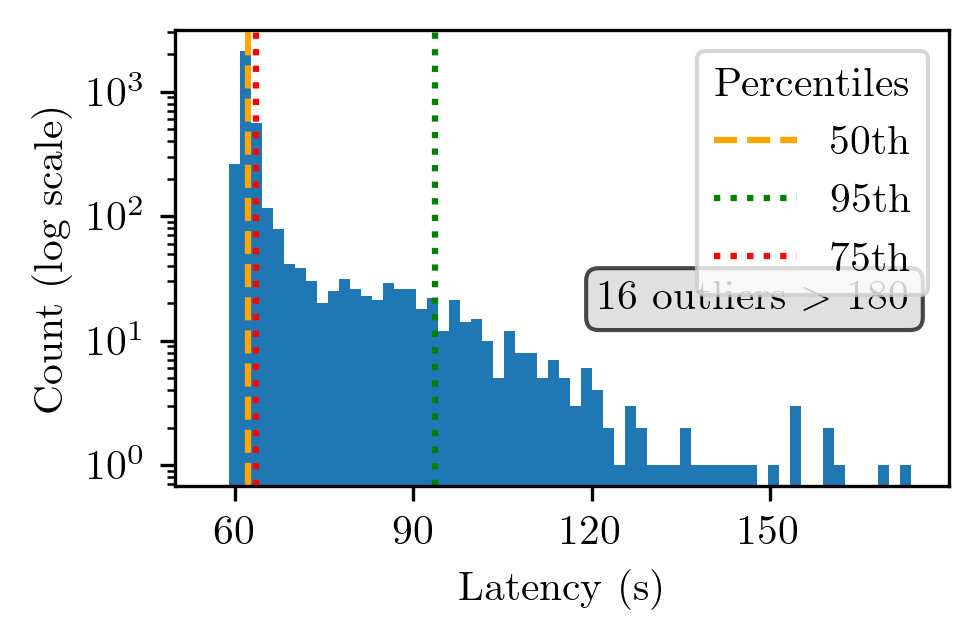

In [48]:
def analyze_ts_latency(peer_packets_df, result_df):
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'timestamp'])

    all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna()) | (all_data['command'] == '1001')
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 2
    valid_conn_ids = valid_conns[valid_conns].index

    all_ts_diffs = []
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        ts_mask = (commands == '1002') & (monero_flags == '1')
        ts_series = pd.Series(timestamps[ts_mask])

        # Get source IP for this connection
        source_ip = conn['source_ip'].iloc[0]

        if len(ts_series) > 2:
            differences = ts_series.diff().dt.total_seconds().dropna()
            all_ts_diffs.extend(differences)
            latency = differences.mean()

            # Append connection info for efficient processing
            conn_info.append({'source_ip': source_ip, 'latency': latency})
        else:
            # If no valid latency, still record the IP with None
            conn_info.append({'source_ip': source_ip, 'latency': None})

    conn_df = pd.DataFrame(conn_info)

    # Calculate average latency per IP (handles None values automatically)
    latency_by_ip = conn_df.groupby('source_ip')['latency'].mean()

    # Add to result_df
    result_df['ts_latency'] = result_df['source_ip'].map(latency_by_ip)

    quantiles = [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    set_plt_latex_format()
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(conn_df['latency'], bins=1000, log=True)
    plt.xlim(50, 180)
    plt.axvline(conn_df['latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(conn_df['latency'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(conn_df['latency'].quantile(0.75), color='red', linestyle=':', label='75th')
    outlier_count = sum(x > 180 for x in conn_df['latency'])
    plt.text(0.95, 0.45, f'{outlier_count} outliers $>$ 180', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Latency (s)')
    plt.xticks([60,90,120,150])
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.savefig('results/graphs/ts_latency_dist.pdf')
    print(f"\nTimed Sync Latency Analysis:")
    print(f"Averaged over {len(conn_df['latency'])} individual connections: {np.mean(conn_df['latency'])}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {conn_df['latency'].quantile(quantile)}")
    
    return result_df

result_df = analyze_ts_latency(peer_packets_df, result_df)



Ping Analysis:
6523 connections.
Percentile distribution of number of Pings sent per connection: 
    0.5th percentile: 1.0
    0.75th percentile: 1.0
    0.9th percentile: 1.0
    0.95th percentile: 24.0
    0.99th percentile: 26.0
Percentile distribution of frequency of Pings if more than one is sent: 
    0.5th percentile: 7.083862882246376
    0.75th percentile: 7.437160142857144
    0.9th percentile: 8.53440258897243
    0.95th percentile: 68.946485
    0.99th percentile: 3794.6990491000124


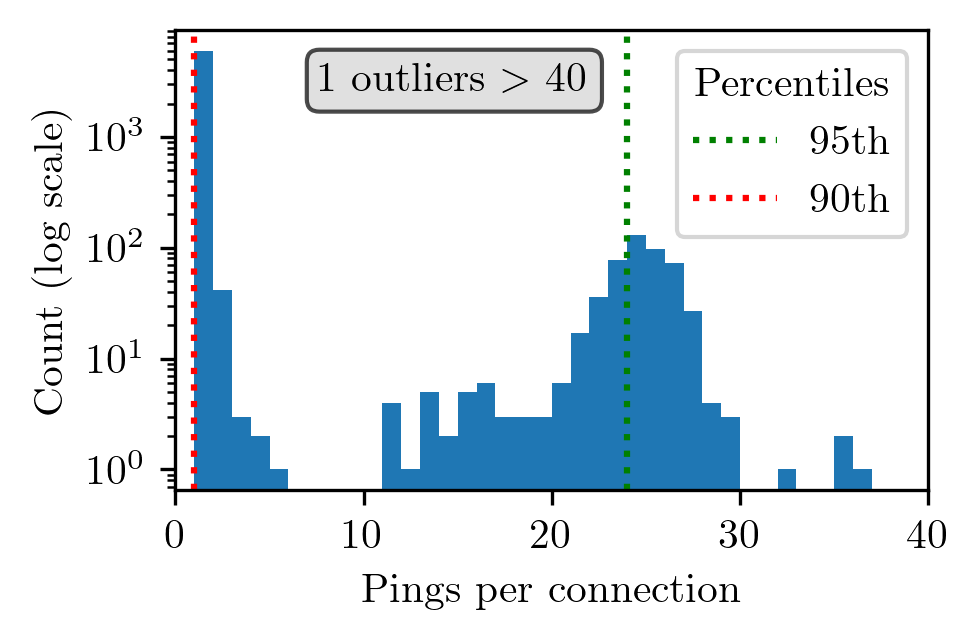

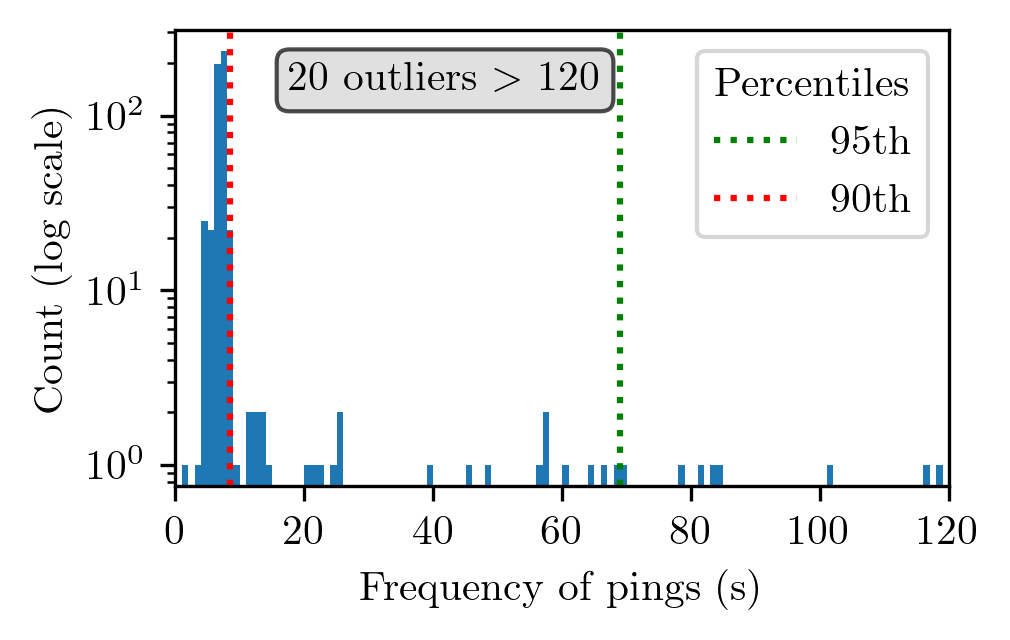


Handshake Analysis:
6523 connections.
Percentile distribution of number of Handshakes sent per connection: 
    0.5th percentile: 1.0
    0.75th percentile: 1.0
    0.9th percentile: 1.0
    0.95th percentile: 1.0
    0.99th percentile: 1.0
    0.999th percentile: 2.478000000000975
Percentile distribution of frequency of Handshakes if more than one is sent: 
    0.5th percentile: 118.850288
    0.75th percentile: 1739.481754
    0.9th percentile: 4959.445274
    0.95th percentile: 14085.235489
    0.99th percentile: 14085.235489
    0.999th percentile: 14989.626473070024


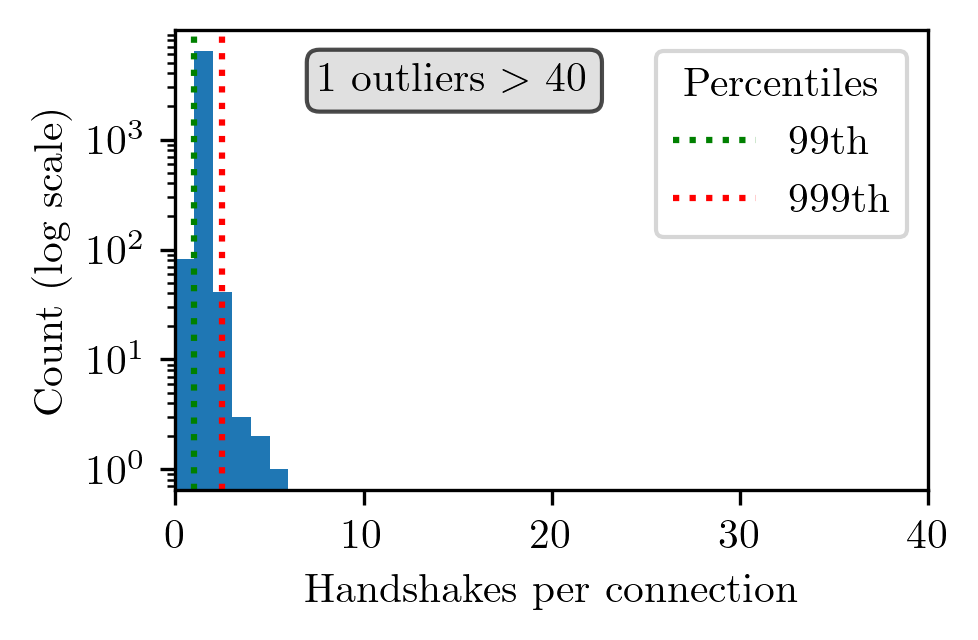

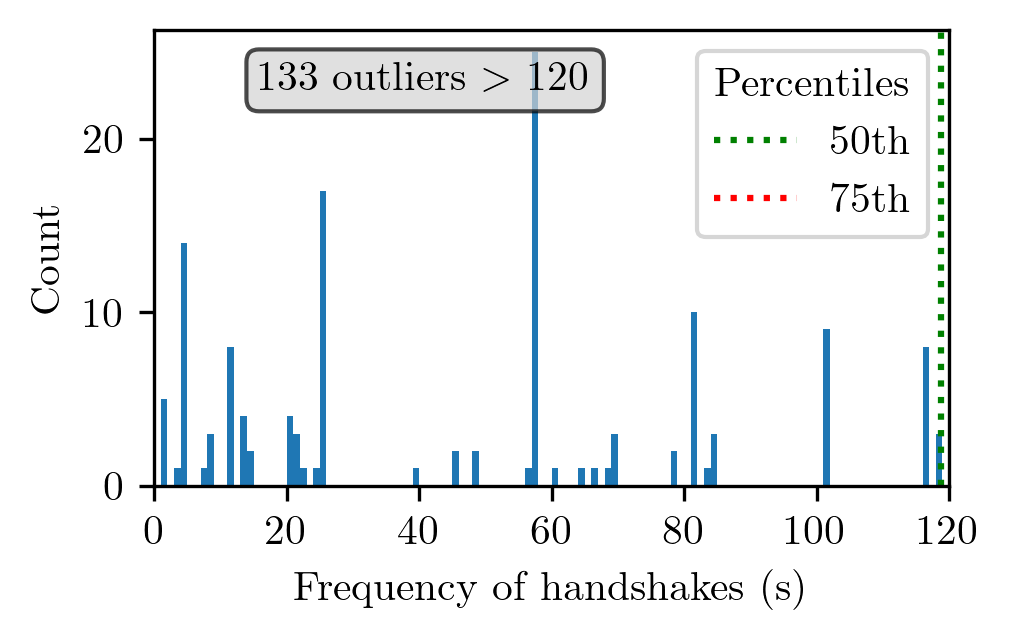

In [ ]:
def analyze_connections(peer_packets_df, result_df):
    # for connection visualization stick to IP and dont split the connection for repeated Handshakes (known pattern)
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'timestamp'])

    all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle connection), or first row
    all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna())
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index
    
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ip = conn['source_ip'].iloc[0]

        conn_row = {
            'source_ip': source_ip,
            'total_pings': 1,
            'ping_frequency': None,
            'total_handshakes': 1,
            'handshake_frequency': None
        }

        # Ping Analysis
        ping_mask = (commands == '1003')
        ping_timestamps = timestamps[ping_mask]
        if len(ping_timestamps) > 1:
            ping_series = pd.Series(ping_timestamps)
            ping_differences = ping_series.diff().dt.total_seconds().dropna()

            conn_row['total_pings'] = len(ping_timestamps)
            conn_row['ping_frequency'] = ping_differences.mean()
        
        # Handshake Analysis
        handshake_mask = (commands == '1001')
        handshake_timestamps = timestamps[handshake_mask]
        if len(handshake_timestamps) > 1:
            handshake_series = pd.Series(handshake_timestamps)
            handshake_diffs = handshake_series.diff().dt.total_seconds().dropna()

            conn_row['total_handshakes'] = len(ping_timestamps)
            conn_row['handshake_frequency'] = ping_differences.mean()
        
        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)

    ping_frequency_by_ip = conn_df.groupby('source_ip')['ping_frequency'].mean()
    pings_by_ip = conn_df.groupby('source_ip')['total_pings'].max()
    result_df['ping_frequency'] = result_df['source_ip'].map(ping_frequency_by_ip)
    result_df['total_pings'] = result_df['source_ip'].map(pings_by_ip)

    handshake_frequency_by_ip = conn_df.groupby('source_ip')['handshake_frequency'].mean()
    handshakes_by_ip = conn_df.groupby('source_ip')['total_handshakes'].max()
    result_df['handshake_frequency'] = result_df['source_ip'].map(handshake_frequency_by_ip)
    result_df['total_handshakes'] = result_df['source_ip'].map(handshakes_by_ip)
    
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(result_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['total_pings'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    plt.axvline(result_df['total_pings'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['total_pings'].quantile(0.9), color='red', linestyle=':', label='90th')

    outlier_count = sum(x > 40 for x in result_df['total_pings'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 40', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['ping_frequency'], bins=120, range=(0, 120), log=True)
    plt.xlim(0, 120)
    plt.axvline(result_df['ping_frequency'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['ping_frequency'].quantile(0.9), color='red', linestyle=':', label='90th')
    
    outlier_count = sum(x > 120 for x in result_df['ping_frequency'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Frequency of pings (s)')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    # Handshake Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
    print(f"\nHandshake Analysis:")
    print(f"{len(result_df['total_handshakes'])} connections.")
    print(f"Percentile distribution of number of Handshakes sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['total_handshakes'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Handshakes if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['handshake_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['total_handshakes'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    plt.axvline(result_df['total_handshakes'].quantile(0.99), color='green', linestyle=':', label='99th')
    plt.axvline(result_df['total_handshakes'].quantile(0.999), color='red', linestyle=':', label='999th')

    outlier_count = sum(x > 40 for x in result_df['total_handshakes'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 40', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per connection')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['handshake_frequency'], bins=120, range=(0, 120))
    plt.xlim(0, 120)
    plt.axvline(result_df['handshake_frequency'].quantile(0.50), color='green', linestyle=':', label='50th')
    plt.axvline(result_df['handshake_frequency'].quantile(0.75), color='red', linestyle=':', label='75th')
    
    outlier_count = sum(x > 120 for x in result_df['handshake_frequency'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Frequency of handshakes (s)')
    plt.ylabel(f'Count')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    #plt.figure(figsize=(3.13, 2), dpi=300)
    #plt.scatter(result_df['ping_frequency'], result_df['total_pings'])
    #plt.xlim(0, 70)
    #plt.ylim(0, 40)
    #plt.show()

# TODO: Validate connection splitting to account for bidirectional connections and handshakes
analyze_connections(peer_packets_df, result_df)